In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

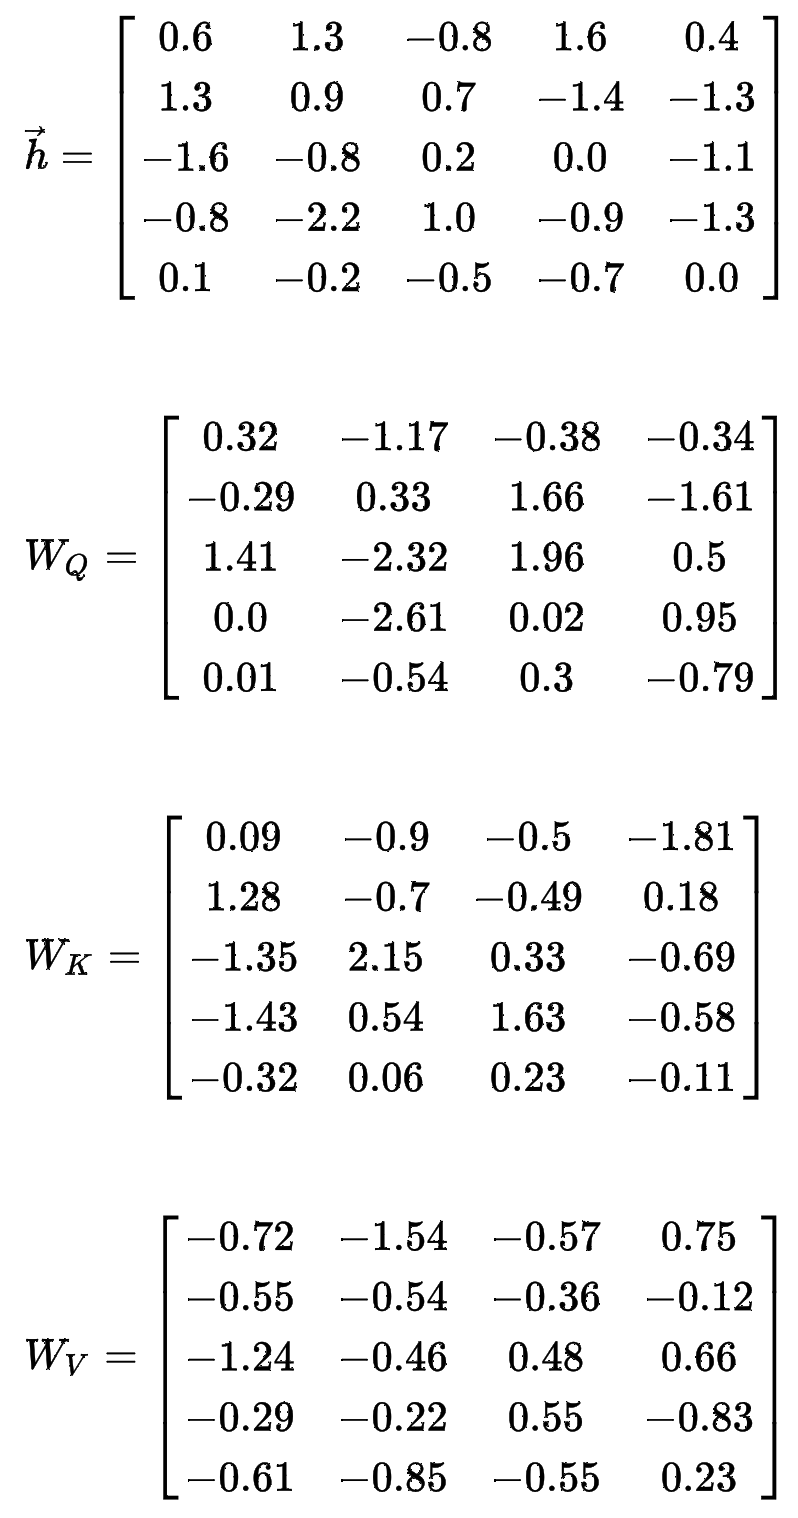

In [ ]:
from torch_geometric.data import HeteroData

data = HeteroData()

data['patient'].x = ... # [num_papers, num_features_paper]
data['drug'].x = ... # [num_authors, num_features_author]
data['diagnosis'].x = ... # [num_institutions, num_features_institution]
data['labevent'].x = ... # [num_field, num_features_field]

data['patient', 'prescribes', 'drug'].edge_index = ... # [2, num_edges_cites]
data['patient', 'has', 'diagnosis'].edge_index = ... # [2, num_edges_writes]
data['patient', 'attributes', 'labevent'].edge_index = ... # [2, num_edges_affiliated]


In [ ]:
import torch
import utils
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing, GCNConv, GATConv
from layers import *
import math 
from torch_scatter import scatter
from torch_geometric.utils import softmax

class GAT(MessagePassing):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 out_dim,
                 num_layers,
                 heads,
                 output_heads,
                 dropout,
                 Normalization='bn'
                 ):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()
        self.normalizations = nn.ModuleList()

        if Normalization == 'bn':
            self.convs.append(GATConv(in_dim, hid_dim, heads))
            self.normalizations.append(nn.BatchNorm1d(hid_dim))
            for _ in range(num_layers-2):
                self.convs.append(GATConv(heads*hid_dim, hid_dim))
                self.normalizations.append(nn.BatchNorm1d(hid_dim))

            self.convs.append(GATConv(heads*hid_dim, out_dim,
                                      heads=output_heads, concat=False))
        else:  # default no normalizations
            self.convs.append(GATConv(in_dim, hid_dim, heads))
            self.normalizations.append(nn.Identity())
            for _ in range(num_layers-2):
                self.convs.append(GATConv(hid_dim*heads, hid_dim))
                self.normalizations.append(nn.Identity())
            self.convs.append(GATConv(hid_dim*heads, out_dim,
                                      heads=output_heads, concat=False))s
        self.dropout = dropout

    def reset_parameters(self):
        for layer in self.convs:
            layer.reset_parameters()
        for normalization in self.normalizations:
            if not (normalization.__class__.__name__ is 'Identity'):
                normalization.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x, inplace=True)
            x = self.normalizations[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero

dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('paper', 'cites', 'paper'): GCNConv(-1, hidden_channels),
                ('author', 'writes', 'paper'): SAGEConv((-1, -1), hidden_channels),
                ('paper', 'rev_writes', 'author'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

model = HeteroGNN(hidden_channels=64, out_channels=dataset.num_classes,
                  num_layers=2)